# Financial Fraud Detection Using PaySim Synthetic Dataset

## Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, make_scorer, log_loss, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import joblib

dataset: https://www.kaggle.com/datasets/sriharshaeedala/financial-fraud-detection-dataset/data

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "Synthetic_Financial_datasets_log.csv"

df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sriharshaeedala/financial-fraud-detection-dataset",
  file_path)

df.head()

/tmp/ipykernel_13/1733154566.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


**DATASET STRUCTURE**  

- **step:** Represents a time unit in the real world, where 1 step equals 1 hour. The total simulation includes 744 steps, equivalent to 30 days.  
- **type:** Transaction type, including **CASH-IN**, **CASH-OUT**, **DEBIT**, **PAYMENT**, and **TRANSFER**.  
- **amount:** The transaction amount in local currency.  
- **nameOrig:** The customer initiating the transaction.  
- **oldbalanceOrg:** The sender’s account balance before the transaction.  
- **newbalanceOrig:** The sender’s account balance after the transaction.  
- **nameDest:** The recipient of the transaction.  
- **oldbalanceDest:** The recipient’s initial balance before the transaction. Not applicable for customers identified by **'M'** (Merchant).  
- **newbalanceDest:** The recipient’s new balance after the transaction. Not applicable for **'M'** (Merchant).  
- **isFraud:** Identifies transactions executed by fraud agents aiming to drain customer accounts through transfers and cash-outs.  
- **isFlaggedFraud:** Flags large and unauthorized transfers between accounts, where any single transaction exceeding **200,000** is considered illegal.



## Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [5]:
numericals = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']
kategoricals = ['type']

In [6]:
df[kategoricals].describe()

,type
count,6362620
unique,5
top,CASH_OUT
freq,2237500


In [7]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [8]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='count'>

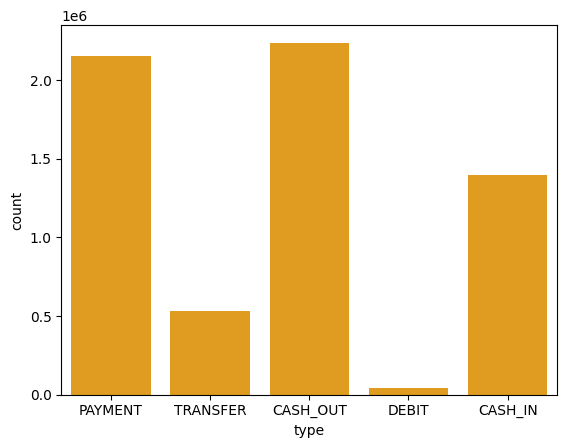

In [9]:
sns.countplot(data=df, x='type', color='orange')

In [10]:
df[numericals].describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_13/4141621528.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


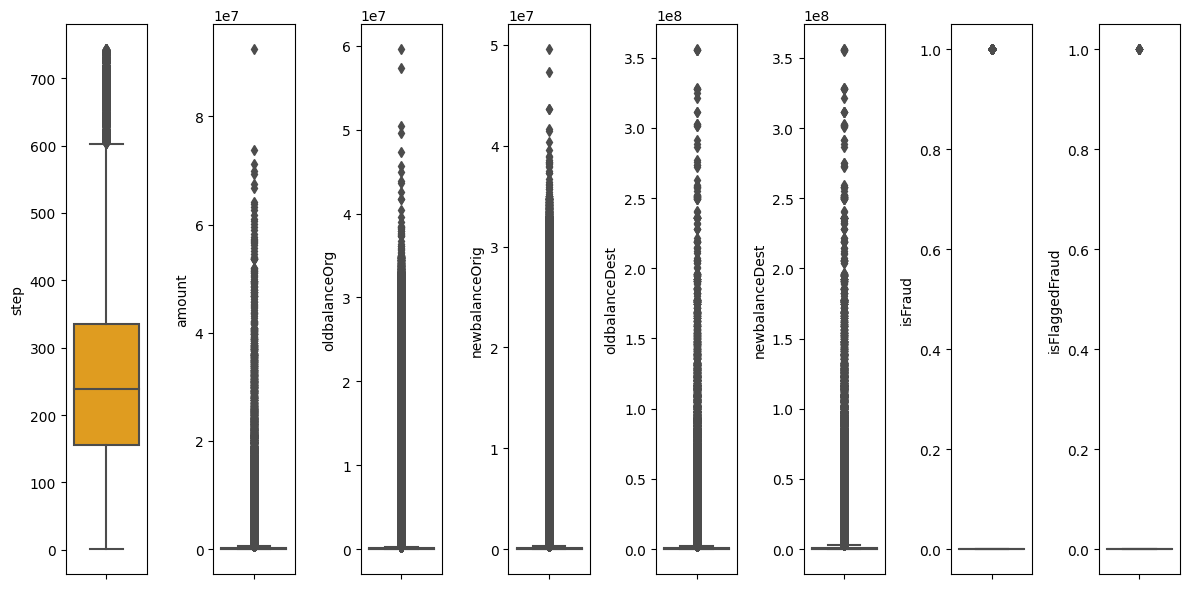

In [11]:
features = numericals
plt.figure(figsize=(12,6))

for i in range(0, len(features)):
    plt.subplot(1, len(features), i+1)
    sns.boxplot(y=df[features[i]], color='orange')
    plt.tight_layout()

/tmp/ipykernel_13/3847201758.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df[features[i]], color='orange')
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_13/3847201758.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for hi

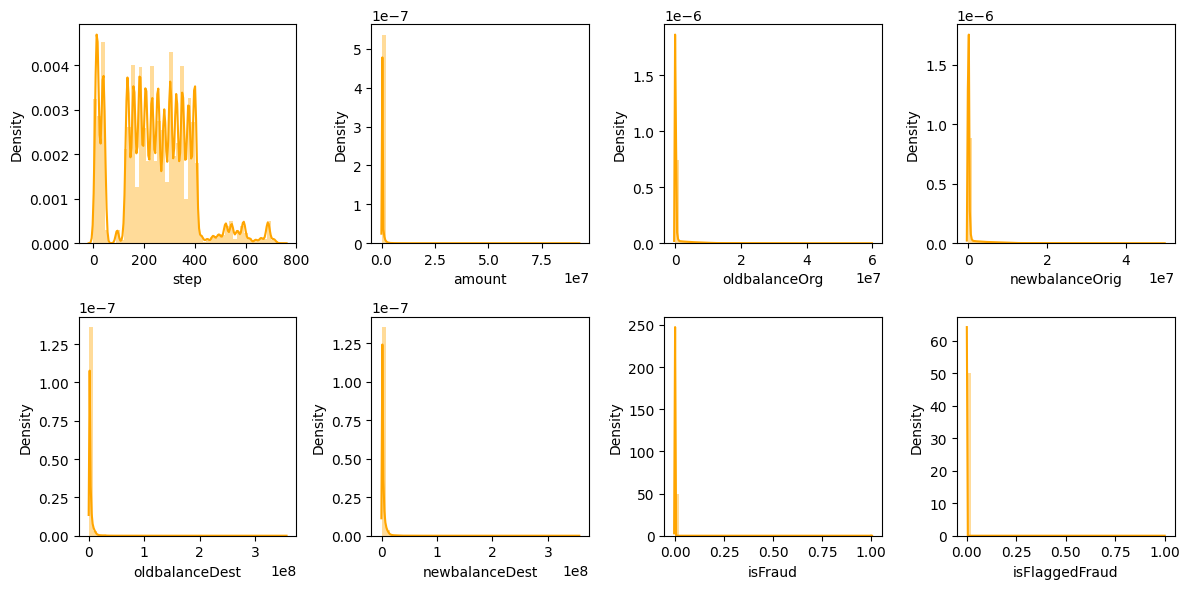

In [12]:
plt.figure(figsize=(12,6))

for i in range(0, len(features)):
    plt.subplot(2, 4, i+1)
    sns.distplot(x=df[features[i]], color='orange')
    plt.xlabel(features[i])
    plt.tight_layout()

## Feature Engineering

In [13]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [14]:
df = df.drop(columns=['nameOrig', 'nameDest'])
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,0


#### Memisahkan data dengan target

In [15]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,0
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,0
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


#### Encoding data

In [16]:
X['is_CASH_IN'] = X['type'].map({'CASH_IN':1, 'PAYMENT':0, 'CASH_OUT':0, 'TRANSFER':0, 'DEBIT':0})
X['is_PAYMENT'] = X['type'].map({'CASH_IN':0, 'PAYMENT':1, 'CASH_OUT':0, 'TRANSFER':0, 'DEBIT':0})
X['is_CASH_OUT'] = X['type'].map({'CASH_IN':0, 'PAYMENT':0, 'CASH_OUT':1, 'TRANSFER':0, 'DEBIT':0})
X['is_TRANSFER'] = X['type'].map({'CASH_IN':0, 'PAYMENT':0, 'CASH_OUT':0, 'TRANSFER':1, 'DEBIT':0})
X['is_DEBIT'] = X['type'].map({'CASH_IN':0, 'PAYMENT':0, 'CASH_OUT':0, 'TRANSFER':0, 'DEBIT':1})

X = X.drop(columns=['type'])

X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,is_CASH_IN,is_PAYMENT,is_CASH_OUT,is_TRANSFER,is_DEBIT
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,0,0,0,0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,0,0,0,1,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,0,0,0


#### Mencari missing value

In [17]:
df.isnull().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [18]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [21]:
X_train.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,is_CASH_IN,is_PAYMENT,is_CASH_OUT,is_TRANSFER,is_DEBIT
6271196,619,386385.08,4669568.85,5055953.92,506035.06,119649.98,0,1,0,0,0,0
1888243,164,212458.78,234635.00,447093.78,806037.88,593579.10,0,1,0,0,0,0
5549957,382,19967.60,3634.00,0.00,0.00,0.00,0,0,1,0,0,0
2025342,180,527616.51,180216.00,0.00,92157.10,619773.61,0,0,0,1,0,0
682342,36,206067.85,0.00,0.00,2131494.48,2337562.32,0,0,0,0,1,0


## Modelling

In [22]:
logreg = LogisticRegression(class_weight='balanced',random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [23]:
# === Save Logistic Regression model and metadata ===
import os, json, joblib

os.makedirs("models", exist_ok=True)

# Save model
joblib.dump(logreg, "models/logreg_model.joblib")

# Save feature order used during training to guarantee correct inference alignment
feature_cols = list(X_train.columns)
with open("models/feature_columns.json", "w") as f:
  json.dump(feature_cols, f)

print("Saved: models/logreg_model.joblib")
print("Saved: models/feature_columns.json")


Saved: models/logreg_model.joblib
Saved: models/feature_columns.json


In [24]:
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)[:,1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model Logistic Regression: {accuracy:.2f}")

Akurasi model Logistic Regression: 0.91


#### Log Loss

In [25]:
logloss_score = log_loss(y_test, y_proba)
print(f"Log loss: {logloss_score:.2f}")

Log loss: 0.33


#### ROC AUC

In [26]:
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.2f}")

ROC AUC Score: 0.96


#### Classification Report

In [27]:
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

recall_train = recall_score(y_train, y_train_pred)
recall_test = recall_score(y_test, y_test_pred)

print(f"Training Recall: {recall_train:.2f}")
print(f"Test Recall: {recall_test:.2f}\n")
print(classification_report(y_test, y_pred))

Training Recall: 0.90
Test Recall: 0.88

              precision    recall  f1-score   support

           0       1.00      0.91      0.95   1270904
           1       0.01      0.88      0.02      1620

    accuracy                           0.91   1272524
   macro avg       0.51      0.90      0.49   1272524
weighted avg       1.00      0.91      0.95   1272524



#### Confusion Matrix dari Logistic Regression

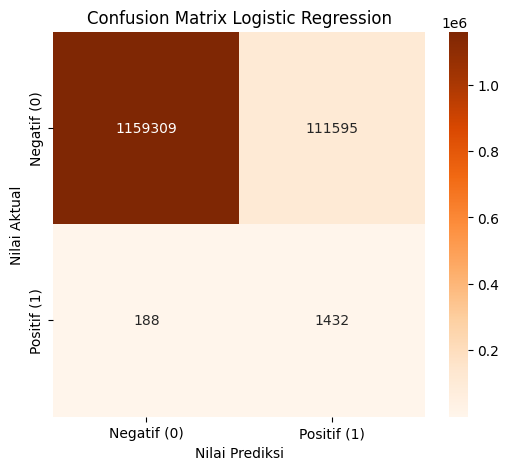

In [28]:
conmax = confusion_matrix(y_test, y_pred)

labels = ['Negatif (0)', 'Positif (1)']
plt.figure(figsize=(6,5))
sns.heatmap(conmax, annot=True, fmt='d',
            cmap='Oranges', xticklabels=labels,
            yticklabels=labels)
plt.xlabel('Nilai Prediksi')
plt.ylabel('Nilai Aktual')
plt.title('Confusion Matrix Logistic Regression')
plt.show()

- **True Positives (TP):** The model predicts **Positive (1)** and the prediction is correct (**Actual is Positive**). ✅ *Desired Outcome*  
- **True Negatives (TN):** The model predicts **Negative (0)** and the prediction is correct (**Actual is Negative**). ✅ *Desired Outcome*  
- **False Positives (FP):** The model predicts **Positive (1)** but the prediction is wrong (**Actual is Negative**). ⚠️ *Type I Error (False Alarm)*  
- **False Negatives (FN):** The model predicts **Negative (0)** but the prediction is wrong (**Actual is Positive**). ⚠️ *Type II Error (Missed Case)*


### Voting Classifier

In [29]:
cat_clf = CatBoostClassifier()
rf_clf = RandomForestClassifier()
xgb_clf = XGBClassifier()

voting_clf = VotingClassifier(
    estimators=[('cat', cat_clf), ('rf', rf_clf), ('xgb', xgb_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

Learning rate set to 0.39419
0:	learn: 0.0590786	total: 666ms	remaining: 11m 5s
1:	learn: 0.0257209	total: 1.17s	remaining: 9m 42s
2:	learn: 0.0145271	total: 1.61s	remaining: 8m 56s
3:	learn: 0.0086509	total: 2.05s	remaining: 8m 30s
4:	learn: 0.0078444	total: 2.49s	remaining: 8m 15s
5:	learn: 0.0037788	total: 3s	remaining: 8m 16s
6:	learn: 0.0025883	total: 3.51s	remaining: 8m 17s
7:	learn: 0.0021992	total: 3.99s	remaining: 8m 15s
8:	learn: 0.0020988	total: 4.59s	remaining: 8m 25s
9:	learn: 0.0019510	total: 5.11s	remaining: 8m 26s
10:	learn: 0.0018377	total: 5.64s	remaining: 8m 27s
11:	learn: 0.0017426	total: 6.16s	remaining: 8m 27s
12:	learn: 0.0016911	total: 6.67s	remaining: 8m 26s
13:	learn: 0.0016743	total: 7.18s	remaining: 8m 25s
14:	learn: 0.0016271	total: 7.74s	remaining: 8m 28s
15:	learn: 0.0016181	total: 8.24s	remaining: 8m 26s
16:	learn: 0.0015718	total: 8.76s	remaining: 8m 26s
17:	learn: 0.0015434	total: 9.26s	remaining: 8m 25s
18:	learn: 0.0015149	total: 9.77s	remaining: 8m 

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x7ca9748d0750>),
                             ('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_typ...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [30]:
# === Save VotingClassifier ensemble and metadata ===
import os, json, joblib

os.makedirs("models", exist_ok=True)

joblib.dump(voting_clf, "models/voting_clf.joblib")

feature_cols = list(X_train.columns)
with open("models/feature_columns.json", "w") as f:
  json.dump(feature_cols, f)

print("Saved: models/voting_clf.joblib")
print("Saved/updated: models/feature_columns.json")


Saved: models/voting_clf.joblib
Saved/updated: models/feature_columns.json


In [31]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test):
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)
    # on training
    recall_train = recall_score(y_train, y_train_pred)
    # on testing dataset
    recall_test = recall_score(y_test, y_test_pred)

    print(f'Training Recall: {recall_train:.3f}')
    print(f'Test Recall: {recall_test:.3f}')
    print("\nClassification Report (Test):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, 
        annot=True,        
        fmt='d',           
        cmap='Oranges',      
        xticklabels=labels,
        yticklabels=labels
    )
    plt.xlabel('Nilai Prediksi')
    plt.ylabel('Nilai Aktual')
    plt.title(f'Confusion Matrix Heatmap Voting Classifier')
    plt.show()

    return recall_train, recall_test

#### Accuracy of Voting Classifier with Classification Report and Confusion Matrix  

This section evaluates the **Voting Classifier’s performance** using two key metrics:  

- **Classification Report:** Provides precision, recall, f1-score, and support for each class (0 = Non-Fraud, 1 = Fraud).  
- **Confusion Matrix:** Displays the number of **True Positives (TP)**, **True Negatives (TN)**, **False Positives (FP)**, and **False Negatives (FN)** — allowing a detailed view of the model’s prediction accuracy and types of errors.

Training Recall: 0.953
Test Recall: 0.854

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.98      0.85      0.91      1620

    accuracy                           1.00   1272524
   macro avg       0.99      0.93      0.96   1272524
weighted avg       1.00      1.00      1.00   1272524



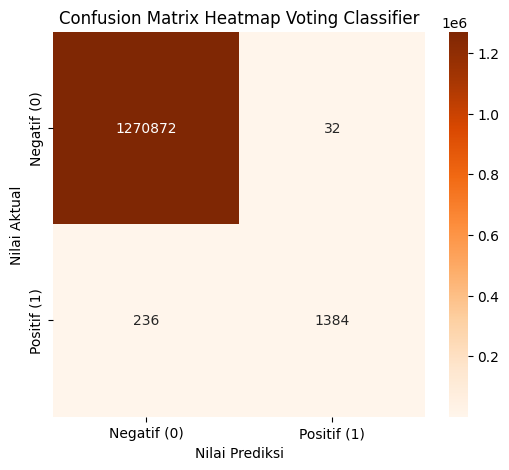

(0.9526770817533748, 0.854320987654321)

In [32]:
evaluate_model(voting_clf, X_train, y_train, X_test, y_test)